# Einführung in CNNs
* Wir haben ein realitätsnahes Beispiel
  * https://twitter.com/art_sobolev/status/907857395757481985?s=03: *I don't think it's fine to only list experiments on toy datasets, and hide failures on more complicated cases.*
* dafür können wir leider nicht alles auf lokalen Rechnern oder Azure trainieren

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib.pylab as plt
import numpy as np

In [4]:
from distutils.version import StrictVersion

In [5]:
import sklearn
print(sklearn.__version__)

assert StrictVersion(sklearn.__version__ ) >= StrictVersion('0.18.1')

0.19.0


In [6]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

assert StrictVersion(tf.__version__) >= StrictVersion('1.1.0')

1.2.1


In [7]:
# We need keras 2.0.6 or later as this is the version our GPU based system used to create some models
!pip install keras --upgrade
# after installation call Restart & Run All in Kernel menu

Requirement already up-to-date: keras in /home/nbcommon/anaconda3_410/lib/python3.5/site-packages
Requirement already up-to-date: pyyaml in /home/nbcommon/anaconda3_410/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: scipy>=0.14 in /home/nbcommon/anaconda3_410/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: six>=1.9.0 in /home/nbcommon/anaconda3_410/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: numpy>=1.9.1 in /home/nbcommon/anaconda3_410/lib/python3.5/site-packages (from keras)


In [7]:
import keras
print(keras.__version__)

assert StrictVersion(keras.__version__) >= StrictVersion('2.0.6')

Using TensorFlow backend.


2.0.8


In [9]:
import pandas as pd
print(pd.__version__)

assert StrictVersion(pd.__version__) >= StrictVersion('0.19.0')

0.19.2


## Laden und Vorbereiten der Bild-Daten

In [ ]:
!curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/speed-limit-signs.zip
from zipfile import ZipFile
zip = ZipFile(r'speed-limit-signs.zip')
zip.extractall('.')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1810k  100 1810k    0     0  1496k      0  0:00:01  0:00:01 --:--:-- 1498k


In [12]:
!ls -l speed-limit-signs

total 0
drwxr-xr-x 2 nbuser nbuser   0 Sep 22 14:08 0
drwxr-xr-x 2 nbuser nbuser   0 Sep 22 14:08 1
drwxr-xr-x 2 nbuser nbuser   0 Sep 22 14:08 2
drwxr-xr-x 2 nbuser nbuser   0 Sep 22 14:08 3
drwxr-xr-x 2 nbuser nbuser   0 Sep 22 14:08 4
drwxr-xr-x 2 nbuser nbuser   0 Sep 22 14:09 5
-rw-r--r-- 1 nbuser nbuser 380 Sep 22 14:09 README.md


In [13]:
!cat speed-limit-signs/README.md

Data extracted from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

From http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip just the samples for the speed limit signs 

## Format

https://en.wikipedia.org/wiki/Netpbm_format

Can be previewed on a Mac and be processed by http://scikit-image.org/

## Labels
- 0: 30
- 1: 50
- 2: 70
- 3: 80
- 4: 100
- 5: 120

# Big Kudos to [Waleed Abdulla](https://medium.com/@waleedka) for providing the initial idea and many of the functions used to prepare and display the images: https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6#.i728o84ib  

In [14]:
import os
import skimage.data
import skimage.transform
from keras.utils.np_utils import to_categorical
import numpy as np

def load_data(data_dir, type=".ppm"):
    num_categories = 6

    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    images64 = [skimage.transform.resize(image, (64, 64)) for image in images]
    return images64, labels

In [15]:
# Load datasets.
ROOT_PATH = "./"
original_dir = os.path.join(ROOT_PATH, "speed-limit-signs")
images, labels = load_data(original_dir, type=".ppm")

In [16]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)

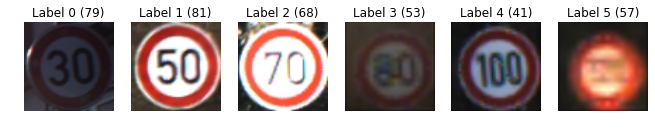

In [17]:
display_images_and_labels(images, labels)

## Modell-Architektur
http://cs231n.github.io/neural-networks-1/#power

### Layout of a typical CNN

![Layout of a typical CNN](https://github.com/DJCordhose/speed-limit-signs/raw/master/img/convnet-layoyt.jpeg)
http://cs231n.github.io/convolutional-networks/

### Classic VGG like Architecture
* we use a VGG like architecture
* based on https://arxiv.org/abs/1409.1556
* basic idea: sequential, deep, small convolutional filters, use dropouts to reduce overfitting
* 16/19 layers are typical
* we choose less layers, because we have limited resources

### Convolutional Blocks: Cascading many Convolutional Layers having down sampling in between

![Applying filters](http://cs231n.github.io/assets/cnn/cnn.jpeg)

http://cs231n.github.io/convolutional-networks/#conv

### Example of a Convolution
#### Original Image
![Dog](https://github.com/DJCordhose/speed-limit-signs/raw/master/img/conv/dog.png)
#### Many convolutional filters applied over all channels
![Dog after Convolutional Filters applied](https://github.com/DJCordhose/speed-limit-signs/raw/master/img/conv/dog-conv1.png)
http://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html

### Downlsampling Layer: Reduces data sizes and risk of overfitting
![Pooling](http://cs231n.github.io/assets/cnn/pool.jpeg)
![Max Pooling](http://cs231n.github.io/assets/cnn/maxpool.jpeg)
http://cs231n.github.io/convolutional-networks/#pool

# Wähle aus einer von 2 Hands-Ons

---

# Hands-On Alternative 1 (Überblick)
## Mache Erfahrungen mit allen Schichten: https://transcranial.github.io/keras-js/#/mnist-cnn
![Keras Browser](https://djcordhose.github.io/ai/img/browser/keras-browser.png)

* Die Architektur für MNIST ist einfacher, aber enthält alle Arten von Schichten, die wir auch hier nutzen 
* Zeichne ein paar Zahlen und sieh dir die Zwischenergebnisse in allen Schichten an

__Nebenbei__: Keras.js kann deine Keras-Modelle auch im Browser ausführen

---

---

# Hands-On Alternative 2  (Funktionsweise)
## Probiere Filter Kernel für CNNs aus: http://setosa.io/ev/image-kernels/
![Image Kernels](https://djcordhose.github.io/ai/img/browser/setosa_io_image-kernels.png)
* Nutze zumindest Sharpen und Blur
* Probiere beide auf einem Verkersschild aus: https://github.com/DJCordhose/speed-limit-signs/raw/master/data/real-world/4/100-sky-cutoff-detail.jpg
* Erzeuge einen eigenen Filter
* Kannst du einen Filter erstellen, der eine schwarze Ausgabe erzeugt?

![100 Speed Limit Sign](https://github.com/DJCordhose/speed-limit-signs/raw/master/data/real-world/4/100-sky-cutoff-detail.jpg)

---

In [18]:
# again a little bit of feature engeneering

y = np.array(labels)
X = np.array(images)
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

In [68]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [69]:
model = Model(input=inputs, output=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 128)       147584    
__________

In [70]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Optimizers: Adam and RMSprop seem nice
![Behavior of Optimizers at Saddle Points](http://cs231n.github.io/assets/nn3/opt1.gif)
![Visualization of Optimizers](http://cs231n.github.io/assets/nn3/opt2.gif)
http://cs231n.github.io/neural-networks-3/#ada

## Zuerst testen wir unser Modell, ob wir es überhaupt trainiert bekommen, indem wir auf einer kleinen Menge von Daten overfitten
http://cs231n.github.io/neural-networks-3/#sanitycheck

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)

In [72]:
X_train.shape, y_train.shape

((37, 64, 64, 3), (37, 6))

In [ ]:
# %time model.fit(X_train, y_train, epochs=50, validation_split=0.3)
%time model.fit(X_train, y_train, epochs=100, validation_split=0.3)

Train on 25 samples, validate on 12 samples
Epoch 1/100
25/25 [==============================] - 1s - loss: 1.7933 - acc: 0.0400 - val_loss: 1.6831 - val_acc: 0.4167
Epoch 2/100
25/25 [==============================] - 1s - loss: 1.7293 - acc: 0.2000 - val_loss: 1.9382 - val_acc: 0.0000e+00
Epoch 3/100
25/25 [==============================] - 1s - loss: 1.7610 - acc: 0.2400 - val_loss: 1.8848 - val_acc: 0.0000e+00
Epoch 4/100
25/25 [==============================] - 1s - loss: 1.7379 - acc: 0.3200 - val_loss: 1.8775 - val_acc: 0.0000e+00
Epoch 5/100
25/25 [==============================] - 1s - loss: 1.6711 - acc: 0.3200 - val_loss: 1.9892 - val_acc: 0.4167
Epoch 6/100
25/25 [==============================] - 1s - loss: 1.6185 - acc: 0.2400 - val_loss: 2.0577 - val_acc: 0.4167
Epoch 7/100
25/25 [==============================] - 1s - loss: 1.5515 - acc: 0.3200 - val_loss: 2.3862 - val_acc: 0.1667
Epoch 8/100
25/25 [==============================] - 1s - loss: 1.5036 - acc: 0.5200 - val

25/25 [==============================] - 1s - loss: 0.1690 - acc: 0.9200 - val_loss: 6.7342 - val_acc: 0.3333
Epoch 69/100
25/25 [==============================] - 1s - loss: 0.1414 - acc: 0.9200 - val_loss: 6.7353 - val_acc: 0.3333
Epoch 70/100
25/25 [==============================] - 1s - loss: 0.0936 - acc: 1.0000 - val_loss: 6.7705 - val_acc: 0.3333
Epoch 71/100
25/25 [==============================] - 1s - loss: 0.0604 - acc: 1.0000 - val_loss: 6.8503 - val_acc: 0.3333
Epoch 72/100
25/25 [==============================] - 1s - loss: 0.0408 - acc: 1.0000 - val_loss: 7.0036 - val_acc: 0.3333
Epoch 73/100
25/25 [==============================] - 1s - loss: 0.0293 - acc: 1.0000 - val_loss: 7.1662 - val_acc: 0.2500
Epoch 74/100
25/25 [==============================] - 1s - loss: 0.0215 - acc: 1.0000 - val_loss: 7.2242 - val_acc: 0.2500
Epoch 75/100
25/25 [==============================] - 1s - loss: 0.0154 - acc: 1.0000 - val_loss: 7.3098 - val_acc: 0.2500
Epoch 76/100
25/25 [=========

## Verlauf der Metriken beim Overfitting
### Accuracy
![Accuracy Overfitting](https://djcordhose.github.io/ai/img/tensorboard/cnn-acc-overfitting.png "Accuracy Overfitting")
### Validation Accuracy
![Validation Accuracy Overfitting](https://djcordhose.github.io/ai/img/tensorboard/cnn-val-acc-overfitting.png "Validation Accuracy Overfitting")

---

# Hands-On: Hauptübung
## Vereinfache die Architektur so weit, bis sie nicht mehr overfitten kann
* reduziere dazu entweder die Layers
* oder die Feature Channels
* Reduziere die Epochen auf ca. 50, damit du schnell experimentieren kannst

Ein solches Modell kann extrem einfach sein und schon dadurch Overfittung verhindern. 

Wir verfolgen hier aber eine andere Philosophie: Wir machen das Modell so komplex wie es unsere Hardware zulässt und nutzen eine andere Methode, um Overfitting zu verhindern.

---

## Overfitting vermeiden mit Dropout

In [74]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

# this is important, try and vary between .4 and .75
drop_out = 0.7

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(drop_out)(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [75]:
model = Model(input=inputs, output=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 128)       73856     
__________

In [42]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Training
* Auf einem GPU basierten System geht das in ein paar Minuten
* Azure Rechner sind relativ schnell, haben aber keine GPU
* Hier dauert jede Epoche ca. 10 Sekunden, bei 500 Epochen = 5000 Sekunden = 1,5 Stunden
* Das können wir nicht warten
* 2 Möglichkeiten:
  1. Du trainierst mit deinem vereinfachten Modell
  2. Wir trainieren mit diesem Notebook gemeinsam ein Modell auf einer K80 GPU
     * dieses Modell wird dann geteilt und jeder macht dann die Auswertung wieder in seinem Notebook
     * Während das Modell trainiert (dauert auf K80 GPU nur ein paar Minuten) sehen wir uns das TensorBoard an und verfolgen das Training
       * Loss, Accuracy, Validation Loss, Validation Accuracy

In [44]:
# https://keras.io/callbacks/#tensorboard
tb_callback = keras.callbacks.TensorBoard(log_dir='./tf_log')
# To start tensorboard
# tensorboard --logdir=/mnt/c/Users/olive/Development/ml/tf_log
# open http://localhost:6006

In [49]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=1)

In [54]:
checkpoint_callback = keras.callbacks.ModelCheckpoint('./model-checkpoints/weights.epoch-{epoch:02d}-val_loss-{val_loss:.2f}.hdf5');

In [51]:
!rm -r tf_log

In [81]:
# Depends on harware GPU architecture, set as high as possible (this works well on K80)
BATCH_SIZE = 500

In [52]:
# %time model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback, early_stopping_callback])
%time model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])
# %time model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 242 samples, validate on 61 samples
Epoch 1/500
242/242 [==============================] - 1s - loss: 1.1399 - acc: 0.5537 - val_loss: 1.8481 - val_acc: 0.3934
Epoch 2/500
242/242 [==============================] - 0s - loss: 1.1650 - acc: 0.5083 - val_loss: 1.9291 - val_acc: 0.4590
Epoch 3/500
242/242 [==============================] - 0s - loss: 1.1924 - acc: 0.5207 - val_loss: 1.8771 - val_acc: 0.4918
Epoch 4/500
242/242 [==============================] - 0s - loss: 1.1175 - acc: 0.5455 - val_loss: 1.9865 - val_acc: 0.4426
Epoch 5/500
242/242 [==============================] - 0s - loss: 1.1362 - acc: 0.4959 - val_loss: 2.1604 - val_acc: 0.4426
Epoch 6/500
242/242 [==============================] - 0s - loss: 1.0366 - acc: 0.5537 - val_loss: 2.2037 - val_acc: 0.4590
Epoch 7/500
242/242 [==============================] - 0s - loss: 1.2770 - acc: 0.5083 - val_loss: 1.7027 - val_acc: 0.4754
Epoch 8/500
242/242 [==============================] - 0s - loss: 1.1607 - acc: 0.5041 

## Idealer Verlauf der Metriken beim vollen Training

100% bei Training und über 95% bei Validation sind möglich, sind bei der Datenmenge aber mit Vorsicht zu genießen

### Accuracy
![Accuracy](https://djcordhose.github.io/ai/img/tensorboard/cnn-acc.png "Accuracy")
### Validation Accuracy
![Validation Accuracy](https://djcordhose.github.io/ai/img/tensorboard/cnn-val-acc.png "Validation Accuracy")

# Sichern des Modells (falls in diesem Notebook trainiert wurde)
* unser Modell ist 55 MB groß, das ist ein wirklich großes Modell

In [34]:
model.save('conv-vgg.hdf5')

In [77]:
!ls -lh

total 0
-rw-r--r-- 1 nbuser nbuser   63 Aug 27 07:32 README.html
drwxr-xr-x 2 nbuser nbuser    0 Sep 22 14:08 __MACOSX
-rw-r--r-- 1 nbuser nbuser 140K Aug 30 11:44 cnn-augmentation.ipynb
-rw-r--r-- 1 nbuser nbuser 1.6M Aug 30 17:27 cnn-comparing-all-models.ipynb
-rw-r--r-- 1 nbuser nbuser 319K Sep 22 15:06 cnn-intro.ipynb
-rw-r--r-- 1 nbuser nbuser 1.3M Sep  7 13:56 cnn-prediction.ipynb
-rw-r--r-- 1 nbuser nbuser 198K Aug 30 17:19 cnn-train-augmented.ipynb
-rw-r--r-- 1 nbuser nbuser  55M Sep 22 15:09 conv-vgg.hdf5
-rw-r--r-- 1 nbuser nbuser 113K Sep 22 14:29 nn-intro.ipynb
drwxr-xr-x 2 nbuser nbuser    0 Sep 22 14:08 speed-limit-signs
-rw-r--r-- 1 nbuser nbuser 1.8M Sep 22 14:08 speed-limit-signs.zip
-rw-r--r-- 1 nbuser nbuser 5.5K Sep 22 14:28 workshop.ipynb


In [78]:
# https://transfer.sh/
# Speichert eure Daten für 14 Tage
!curl --upload-file conv-vgg.hdf5 https://transfer.sh/conv-vgg.hdf5

# Vortrainiertes Modell
# loss: 0.0310 - acc: 0.9917 - val_loss: 0.4075 - val_acc: 0.9508
# https://transfer.sh/B1W8e/conv-vgg.hdf5

https://transfer.sh/M5SOs/conv-vgg.hdf5

# ODER Laden des trainierten Modells

In [59]:
!ls -lh

total 2.0M
-rw-rw-r-- 1 ubuntu ubuntu 131K Aug 29 08:29 cnn-intro.ipynb
drwxrwxr-x 3 ubuntu ubuntu 4.0K Aug 29 07:45 __MACOSX
-rw------- 1 ubuntu ubuntu 4.8K Aug 29 08:29 nohup.out
drwxrwxr-x 8 ubuntu ubuntu 4.0K Aug 29 07:45 speed-limit-signs
-rw-rw-r-- 1 ubuntu ubuntu 1.8M Aug 29 07:45 speed-limit-signs.zip
drwxr-xr-x 2 ubuntu ubuntu 4.0K Aug 29 08:17 tf_log


In [58]:
!rm conv-vgg.hdf5

In [1]:
# anpassen an aktuelles Modell
# Nachricht an Olli: Liegt auch local auf Ollis Rechner und kann zur Not von da hochgeladen werden (ai/models/conv-vgg.hdf5)
!curl -O https://transfer.sh/B1W8e/conv-vgg.hdf5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 54.8M  100 54.8M    0     0  4515k      0  0:00:12  0:00:12 --:--:-- 3854k


In [61]:
!ls -lh

total 57M
-rw-rw-r-- 1 ubuntu ubuntu 131K Aug 29 08:31 cnn-intro.ipynb
-rw-rw-r-- 1 ubuntu ubuntu  55M Aug 29 08:30 conv-vgg.hdf5
drwxrwxr-x 3 ubuntu ubuntu 4.0K Aug 29 07:45 __MACOSX
-rw------- 1 ubuntu ubuntu 4.9K Aug 29 08:31 nohup.out
drwxrwxr-x 8 ubuntu ubuntu 4.0K Aug 29 07:45 speed-limit-signs
-rw-rw-r-- 1 ubuntu ubuntu 1.8M Aug 29 07:45 speed-limit-signs.zip
drwxr-xr-x 2 ubuntu ubuntu 4.0K Aug 29 08:17 tf_log


In [79]:
from keras.models import load_model
model = load_model('conv-vgg.hdf5')

# Bewertung

In [82]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

37/37 [==============================] - 0s


(0.43861934542655945, 0.97297298908233643)

In [84]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

342/342 [==============================] - 7s


(0.28564885258674622, 0.95029240846633911)

# Ausprobieren auf ein paar Test-Daten

In [86]:
import random

# Pick 10 random images for test data set
random.seed(4) # to make this deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

In [88]:
ground_truth = np.argmax(sample_labels, axis=1)
ground_truth

array([1, 1, 2, 0, 2, 1, 3, 3, 4, 4])

In [89]:
X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

array([0, 1, 2, 0, 2, 1, 3, 3, 4, 4])

In [90]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

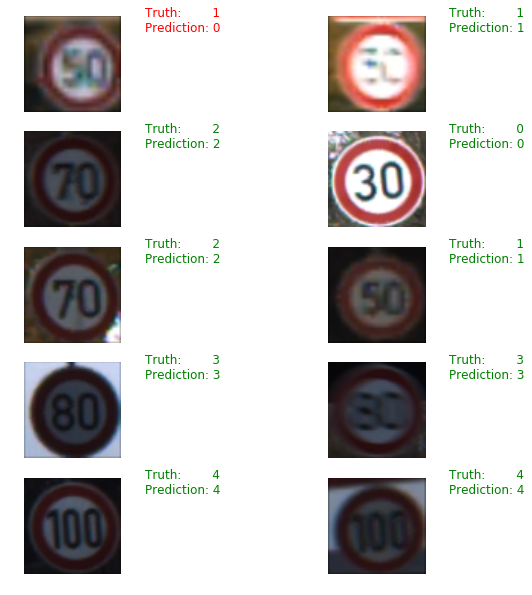

In [91]:
display_prediction(sample_images, ground_truth, predicted_categories)